# Two-point Boundary Value Problem
## Free Final time with Cubic Dynamics 

**Goal:**  (Notes 5-8)
$$\min J = \frac{1}{2} \int_{t_0}^{t_f} \left[v^2(t)+u^2(t)\right] dt$$
with $t_f$ fixed, $x_f$ free, and dynamics
$
\dot v = \alpha v^3 + u
$

- Optimal solution must satisfy $u(t) = - p(t)$ and that
\begin{eqnarray}
\dot v(t) &=& \alpha v(t)^3 - p(t)\\
\dot p(t) &=& -v(t) - 3\alpha v(t)^2 p(t)
\end{eqnarray}
where $v(t_0)$ given and since the end point is free, then we need $p(t_f)=0$

- Will compare the optimal with an approximate "model inversion" type controller
$$
u_a(t) = -\beta x_a(t) - \alpha x^3_a(t)
$$
which results in closed-loop dynamics $\dot x_a(t) = -\beta x_a(t)$.

In [10]:
from os.path import exists
file_exists = exists('basic_material.py')
if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/ecrbitp4tig1jq6/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

file_exists = exists('./figs')
if (not file_exists):
    print("making ./figs")
    !mkdir ./figs

file_exists = exists('./data')
if (not file_exists):
    print("making ./data")
    !mkdir ./data

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *

#https://or.stackexchange.com/questions/7145/how-to-install-ipopt-on-google-colab-for-pyomo/7173#7173
if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
print(shutil.which("ipopt"))

Running Python: 3.8.16
/usr/local/bin/ipopt


In [11]:
alpha = -0.5 # system dynamics
beta = 0.9 # approx control gain

def my_solve(x0=1,xf=1): # create a model object
    if (xf == 0): # with create non-sensical results
        xf = 0.1

    # collocation parameters
    NFE = 100
    NCP = 3

    m = ConcreteModel()

    # define the independent variable
    m.t = ContinuousSet(bounds=(0,1))
    m.tf = Var(domain=NonNegativeReals)
    # define control inputs
    m.u = Var(m.t)

    # define the dependent variables
    m.x1 = Var(m.t)  # x1 = v
    m.p = Var(m.t)

    # define derivatives
    m.x1_dot = DerivativeVar(m.x1, wrt=m.t)
    m.p_dot = DerivativeVar(m.p, wrt=m.t)

    m.ode_x1 = Constraint(m.t, rule=lambda m, t: m.x1_dot[t] == m.tf*(alpha*m.x1[t]**3+m.u[t]))
    m.ode_p = Constraint(m.t, rule=lambda m, t: m.p_dot[t] == m.tf*(-m.x1[t]-3*alpha*m.x1[t]**2*m.p[t]))

    # initial conditions
    m.pc = ConstraintList()
    m.pc.add(m.x1[0]==x0)
    # final conditions
    m.pc.add(m.x1[1]==xf)
    m.pc.add(0.5*(m.x1[1]**2+(m.u[1])**2)+m.p[1]*(alpha*m.x1[1]**3+m.u[1])==0)

    def _con(m, t):
          return m.u[t]== -m.p[t]
    m.con = Constraint(m.t, rule=_con)

    # compute cost so that we can evaluate it - not used in optimization
    m.J = Var(m.t)
    m.J_dot = DerivativeVar(m.J)
    m.ode_J = Constraint(m.t, rule=lambda m, t: m.J_dot[t] == m.tf*(m.x1[t]**2 + m.u[t]**2)/2)
    m.pc.add(m.J[0]==0)

    m.xapprox = Var(m.t)  
    m.uapprox = Var(m.t)  
    m.xapprox_dot = DerivativeVar(m.xapprox, wrt=m.t)
    m.ode_xapprox = Constraint(m.t, rule=lambda m, t: m.xapprox_dot[t] == m.tf*(alpha*m.xapprox[t]**3+m.uapprox[t]))
    m.Japprox = Var(m.t)
    m.Japprox_dot = DerivativeVar(m.Japprox)
    m.ode_Japprox = Constraint(m.t, rule=lambda m, t: m.Japprox_dot[t] == m.tf*(m.xapprox[t]**2 + m.uapprox[t]**2)/2)
    m.pc.add(m.xapprox[0]==x0)
    m.pc.add(m.Japprox[0]==0)

    def _con2(m, t):
          return m.uapprox[t] == -beta*m.xapprox[t] - alpha*m.xapprox[t]**3
    m.con2 = Constraint(m.t, rule=_con2)

    # transform and solve
    TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=100, scheme='BACKWARD')
    solver = SolverFactory('ipopt', keepfiles=True, log_file='log', soln_file='sol')
    solver.options['max_iter']           = 10000
    solver.options['print_level']        = 2
    results = solver.solve(m, tee=True)
    print("Solution result is: ",results.solver.termination_condition)

    return m

## Compute Specific Result

Ipopt 3.13.4: max_iter=10000
print_level=2


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solution result is:  optimal
Some measure of accuracy (should be zero) 4.3661E-02
Term cond accuracy (should be zero) -3.5440E-10
Time length = 0.323 seconds
Resulting Cost 0.302


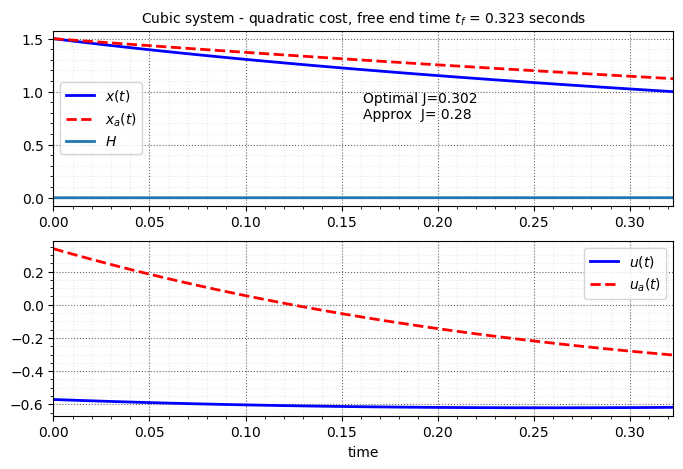

In [12]:
x0 = 1.5  # Initial x
xf = 1  # Final x
m = my_solve(x0,xf)

tf=m.tf()
# access the results
tt = np.array([t*tf for t in m.t])
x1 = np.array([m.x1[t]() for t in m.t])
u = np.array([m.u[t]() for t in m.t])
p = np.array([m.p[t]() for t in m.t])
J = np.array([m.J[t]() for t in m.t])[-1]

xapprox = np.array([m.xapprox[t]() for t in m.t])
uapprox = np.array([m.uapprox[t]() for t in m.t])
Ja = np.array([m.Japprox[t]() for t in m.t])[-1]

# Hamiltonian
H = 0.5*(x1**2 + u**2) + p*(u + alpha*x1**3)
term_cond = 0.5*(x1[-1]**2+(u[-1])**2)+p[-1]*(alpha*x1[-1]**3+u[-1])

print('Some measure of accuracy (should be zero) {:.4E}'.format(np.sum(np.abs(H))))
print('Term cond accuracy (should be zero) {:.4E}'.format(term_cond))
print('Time length = ' + str(round(m.tf(),3)) + ' seconds')
print('Resulting Cost '+str(round(J,3)))

plt.figure(1,figsize=(8,5))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
nicegrid(ax1)
ax1.set_title(f'Cubic system - quadratic cost, free end time $t_f$ = {tf:.3f} seconds')
ax1.plot(tt, x1, 'b-',label=r'$x(t)$')
ax1.plot(tt, xapprox, 'r--',label=r'$x_a(t)$')
ax1.plot(tt, H, ls='-', lw=2,label=r'$H$')
ax2.plot(tt, u, 'b-',label=r'$u(t)$')
ax2.plot(tt, uapprox, 'r--',label=r'$u_a(t)$')
ax2.set_xlabel('time')
ax1.set_xlim([0, tf])
ax2.set_xlim([0, tf])
ax1.text(tf/2,x0/2,'Optimal J='+str(round(J,3))+'\nApprox  J= '+str(round(Ja,3)))
ax1.legend(loc='best')
ax2.legend(loc='best')
nicegrid(ax2)
plt.savefig("figs/Cubic_free_case1.png")
plt.show()

## Experiment

In [13]:
def func(Initial_x = 1, Final_x = 0.1 ):
    x0 = Initial_x     # Initial x
    xf = Final_x      # Final x
    m = my_solve(x0,xf)

    tf=m.tf()
    # access the results
    tt = np.array([t*tf for t in m.t])
    x1 = np.array([m.x1[t]() for t in m.t])
    u = np.array([m.u[t]() for t in m.t])
    p = np.array([m.p[t]() for t in m.t])
    J = np.array([m.J[t]() for t in m.t])[-1]

    xapprox = np.array([m.xapprox[t]() for t in m.t])
    uapprox = np.array([m.uapprox[t]() for t in m.t])
    Ja = np.array([m.Japprox[t]() for t in m.t])[-1]

    # Hamiltonian
    H = 0.5*(x1**2 + u**2) + p*(u + alpha*x1**3)
    term_cond = 0.5*(x1[-1]**2+(u[-1])**2)+p[-1]*(alpha*x1[-1]**3+u[-1])

    print('Some measure of accuracy (should be zero) {:.4E}'.format(np.sum(np.abs(H))))
    print('Term cond accuracy (should be zero) {:.4E}'.format(term_cond))
    print('Time length = ' + str(round(m.tf(),3)) + ' seconds')
    print('Resulting Cost '+str(round(J,3)))

    plt.figure(1,figsize=(8,5))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)

    ax1.set_title(f'Cubic system - quadratic cost, free end time $t_f$ = {tf:.3f} seconds')
    ax1.plot(tt, x1, 'b-',label=r'$x_{optimal}(t)$')
    ax1.plot(tt, xapprox, 'r--',label=r'$x_{approx}(t)$')
    ax1.plot(tt, H, ls='-', lw=2,label=r'$H=0$?')
    ax1.text(tf/2,2*x0/3,'$J_{Optimal}$='+str(round(J,3))+'\n$J_{Approx}$= '+str(round(Ja,3)))
    ax1.legend(loc='best')
    ax1.set_xlim([0, tf])
    nicegrid(ax1)

    ax2.plot(tt, u, 'b-',label=r'$u_{optimal}(t)$')
    ax2.plot(tt, uapprox, 'r--',label=r'$u_{approx}(t)$')
    ax2.set_xlabel('time')
    ax2.set_xlim([0, tf])
    ax2.legend(loc='best')
    nicegrid(ax2)

    plt.savefig("figs/Cubic_free_case1a.png")
    plt.show()

y = interactive(func,{'manual': False},Initial_x=(0,10,.25),Final_x=(0,.5,.1))
y

interactive(children=(FloatSlider(value=1.0, description='Initial_x', max=10.0, step=0.25), FloatSlider(value=…